# Predicting customer leakage for a telephone company

A phone company is interested in developing a model that predicts the **100 current customers** that are most likely to leave the company. For this, they provide us with a database **customer_leakage_labeled.csv** with labeled cases, which will be used to build our prediction model.

The fields in this database are:

* **Customer ID**

* **network_age:** customer tenure in days

* **Customer tenure in months:** customer tenure in months

* **Total Spend in Months 1 and 2:** total customer spending in months 1 and 2

* **Total SMS Spend:** total SMS spend

* **Total Data Spend:** total data / internet spend

* **Total Data Consumption:** total data consumption (in KB) during the study period

* **Total Unique Calls:** total number of unique calls

* **Total Onnet spend:** total expenditure on calls to other users on the same telephone network

* **Total Offnet spend:** total expenditure on calls to other users of different telephone networks

* **Total Call center complaint calls:** number of complaint calls to the call center

* **Network type subscription in Month 1:** Network type subscription in month 1. This indicates a customer's preferred network subscription, which may indicate their device type: 2G or 3G service

* **Network type subscription in Month 2:** same as above but in the following month

* **Churn Status:** the value is 1 if the customer leaves the telephone company, 0 if he stays there

* **Most Loved Competitor network in Month 1:** which other competitor provider the customer prefers in month 1. It's actually a set of columns, each one focused on a particular provider

* **Most Loved Competitor network in Month 2:** which other competing provider the customer prefers in month 2. It's actually a set of columns, each one focused on a particular provider

The variable to predict is **Churn Status**: the value is 1 if the customer **leaves** the company, 0 if he does not leave it.

The company also provides us with another database, **customer_leakage_to_predict.csv**, with information on clients for whom it is not known right now whether or not they will remain with the company. Therefore in this second database all the values of the column **Churn Status** are missing values (NaN).

The company asks us to provide the IDs of the 100 clients in the second database that are most likely to leave the company. To do this, we will provide the company with a csv file with a single column, **Customer ID**, and 100 rows containing the selected customer IDs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from functools import reduce
from random import sample

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

## Load files

In [2]:
data_labeled = pd.read_csv("data/customer_leakage_labeled.csv")
data_to_predict  = pd.read_csv("data/customer_leakage_to_predict.csv")

In [3]:
# Check if all columns are the same in both datasets
assert(data_labeled.columns.equals(data_to_predict.columns))

In [4]:
# Check that Churn Status only takes values of 0 and 1
set(data_labeled["Churn Status"])

{0, 1}

In [5]:
# Check that Churn Status is Nan in "to_predict" data
print(data_to_predict["Churn Status"].isnull().all())

True


## Preprocessing
We preprocess the data, both "labeled" and "to_predict" data. Let's first remove *Churn Status*, as it is not an attribute, and *Customer ID*, as it does not help us to model the problem. After that, the distribution of each feature is plotted, so we get a graphical approach on which columns should be more useful

In [6]:
features = list(data_labeled.columns)
features.remove("Churn Status")
features.remove("Customer ID")  # Remove ID, since it is useless for the model


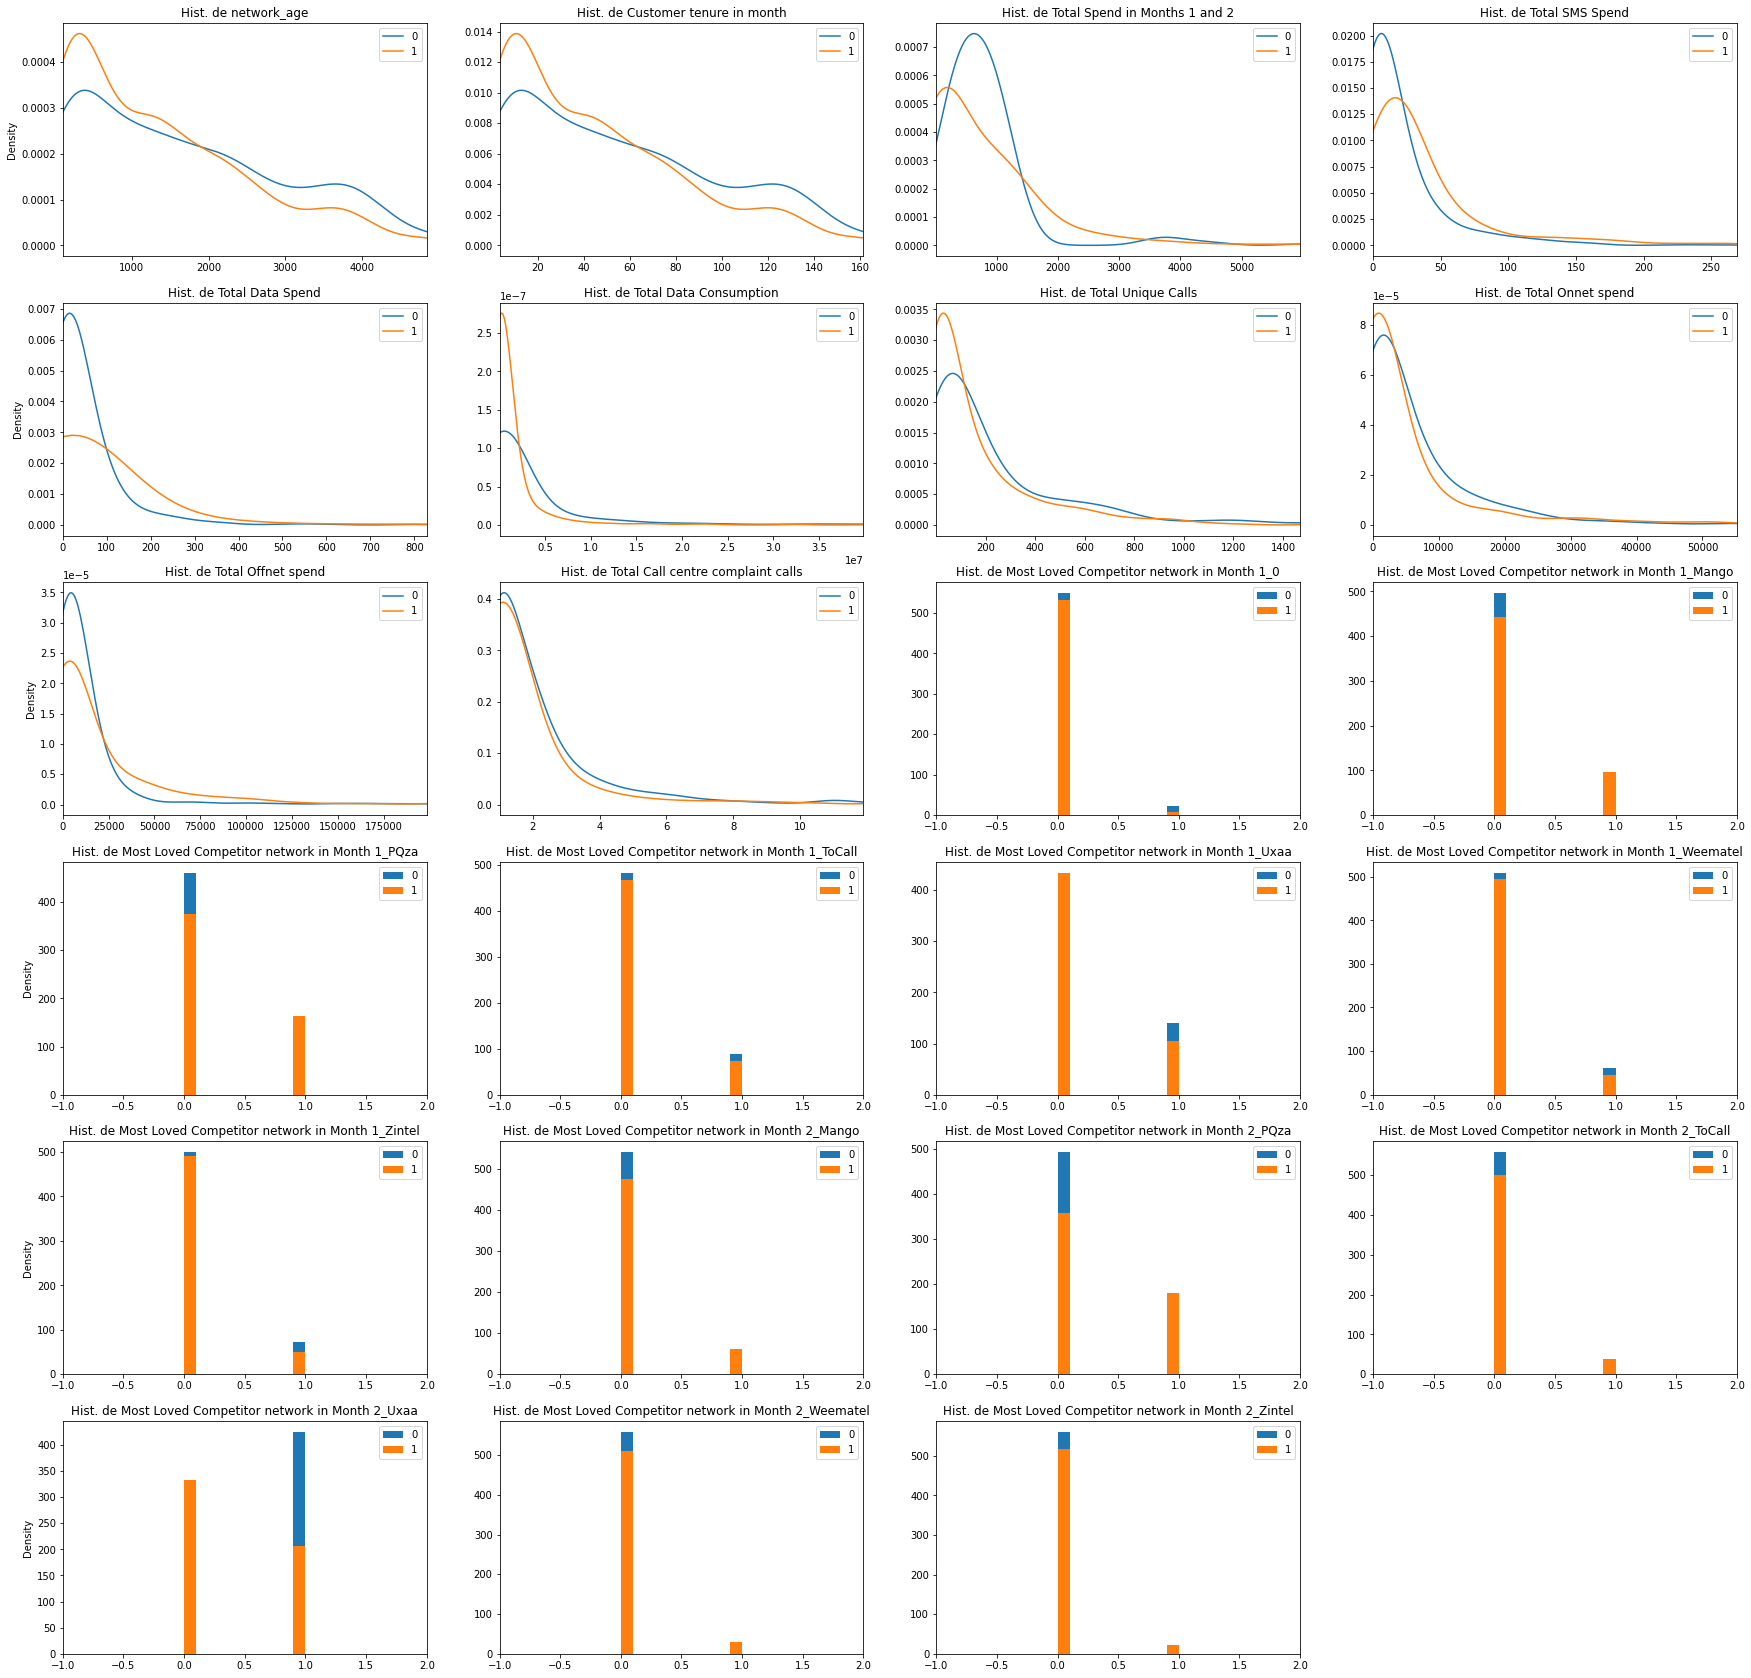

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(30, 30))
for i, name in enumerate(features):
    plt.subplot(6,4, i + 1)
    aux = "Density" if i % 4 == 0 else ''
    
    number_of_values = data_labeled[name].nunique()
    if number_of_values == 2:
        kind = "hist"
        xmin = -1
        xmax = 2
    else:
        kind = "kde"
        xmin = data_labeled[name].quantile(0.01)
        xmax = data_labeled[name].quantile(0.99)
    data_labeled.groupby("Churn Status")[name].plot(kind=kind, title=f"Hist. de {name}", xlim=(xmin, xmax), legend=True)
    plt.ylabel(aux);

### Total Call Centre Complaint Calls
Although it seems completely counterintuitive, looking at the histogram we realize that there does not seem to be a correlation between the number of complaint calls and the *Churn Status*. Thinking that there may be an error with this, we did some simple checks:

Average: 1.9864864864864864
Median: 1.0
Mode: 1
Max: 49


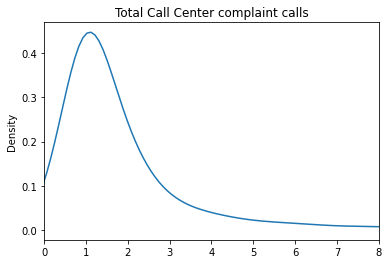

In [8]:
complain_calls = data_labeled["Total Call centre complaint calls"]
complain_calls.plot.kde(xlim=(0, 8), title="Total Call Center complaint calls").figure
print(f"Average: {complain_calls.mean()}")
print(f"Median: {complain_calls.median()}")
print(f"Mode: {complain_calls.mode()[0]}")
print(f"Max: {complain_calls.max()}")

We see that it is a heave-tailed distribution with, that is, most customers call little to complain, but some of them call many times. To finish convincing ourselves that there was no relationship, we printed a list of the customers who made the most complaint calls along with the *Churn Status*.

In [9]:
data_labeled.sort_values(by="Total Call centre complaint calls", 
                               ascending=False)[["Total Call centre complaint calls", "Churn Status"]].head(10)

,Total Call centre complaint calls,Churn Status
457,49,1
449,21,1
827,18,1
520,16,0
469,15,1
557,14,0
654,14,0
887,13,0
779,13,1
510,12,0


Although with the data at hand there does not seem to be a correlation between this attribute and the *Churn Status*, as it is only an attribute (not like the competitors, which will be commented next) we are not going to eliminate it. The models themselves will not take the attribute into account if it does not provide additional information.

### Competitors
As the attributes related to competitors that customers are interested in are too many, we thought that perhaps this information was being given too much importance. Therefore, we are going to see which of these attributes give us a greater information gain.

In [10]:
from math import log2
from numpy import round

def b(p):
    if p == 0 or p == 1:
        return 0
    
    q = 1 - p
    return -(p*log2(p) + q*log2(q))

def entropy(column):
    p = column.value_counts()[0] / column.count()
    return b(p)

initial_entropy = entropy(data_labeled["Churn Status"])
for name in list(features):
    number_of_values = data_labeled[name].nunique()
    
    if number_of_values == 2:
        df_true = data_labeled[data_labeled[name] == 0]
        df_false = data_labeled[data_labeled[name] == 1]
        
        p = df_true.shape[0] / (data_labeled.shape[0])
        q = 1 - p
        
        entropy_true = entropy(df_true["Churn Status"])
        entropy_false = entropy(df_false["Churn Status"])
        
        gain = initial_entropy - (p*entropy_true + q*entropy_false)
        gain = round(gain, 2)
        
        print(f"{name} has an information gain of {round(gain, 2)}")
        if gain < 0.01:
            features.remove(name)

Most Loved Competitor network in Month 1_0 has an information gain of 0.0
Most Loved Competitor network in Month 1_Mango has an information gain of 0.0
Most Loved Competitor network in Month 1_PQza has an information gain of 0.01
Most Loved Competitor network in Month 1_ToCall has an information gain of 0.0
Most Loved Competitor network in Month 1_Uxaa has an information gain of 0.0
Most Loved Competitor network in Month 1_Weematel has an information gain of 0.0
Most Loved Competitor network in Month 1_Zintel has an information gain of 0.0
Most Loved Competitor network in Month 2_Mango has an information gain of 0.01
Most Loved Competitor network in Month 2_PQza has an information gain of 0.04
Most Loved Competitor network in Month 2_ToCall has an information gain of 0.01
Most Loved Competitor network in Month 2_Uxaa has an information gain of 0.1
Most Loved Competitor network in Month 2_Weematel has an information gain of 0.0
Most Loved Competitor network in Month 2_Zintel has an info

Numerically, what we already suspected by looking at the histograms is confirmed, *Most Loved Competitor network in Month 2_Uxaa* gives us more information than others. For this reason, we are going to only keep attributes that give us a gain greater than 0.01 bits.

### Customer tenure

We see that the histograms for *network_age* and *Customer tenure in month* are almost the same in shape, since one attribute is the customer seniority in days and the other in months. Let's confirm this with a quick calculation

In [11]:
np.round(data_labeled["network_age"] / data_labeled["Customer tenure in month"]).unique()

array([30., 29., 31.])

We confirm that the first column (*network_age*) is always 29, 30 or 31 times the second (*Customer tenure in month*). Therefore, we can eliminate the second without losing any information.

In [12]:
features.remove("Customer tenure in month")

### Standardization

As the end point of data preprocessing, we proceed to standardize the attribute values. On the other hand, we perform a random partition that contains 10% of the data to have a Test set with which to analyze the behavior of the model and verify that there is no *overfitting*.

In [13]:
X = data_labeled[features].values
y = data_labeled["Churn Status"].values
# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X_to_predict = data_to_predict[features].values
scaler.transform(X_to_predict)

array([[-0.49080835,  0.03310674, -0.37419083, ..., -0.55167728,
        -0.2239239 ,  0.86967184],
       [-1.09484267,  0.03315988,  4.49349529, ..., -0.55167728,
        -0.2239239 ,  0.86967184],
       [ 1.80656697,  0.04816834, -0.25490487, ..., -0.55167728,
        -0.2239239 ,  0.86967184],
       ...,
       [-1.02956292,  0.23416634, -0.18510808, ..., -0.55167728,
        -0.2239239 , -1.14985901],
       [-1.10349421, -0.59969301, -0.52368224, ..., -0.55167728,
        -0.2239239 , -1.14985901],
       [-0.4782243 , -0.51160088, -0.52368224, ..., -0.55167728,
        -0.2239239 , -1.14985901]])

## Auxiliary functions
First, we define an auxiliary function that each of the models will use. This predicts the *Churn Status* of the "to_predict" data, orders the clients from highest to lowest probability of leaving and, optionally, writes the results in a CSV in the required format (that is, only the first 100 and only the column Customer ID). Secondly, we define a function that calculates the error of the model trained with the test partition, indicating the percentage of correct answers, false positives and false negatives.

In [14]:
def get_best_ids(model, csv_name: str = None) -> pd.DataFrame:
    model.fit(X, y)  # Train model
    y_explotacion = model.predict_proba(X_to_predict)[:, 1]
    
    prediction = pd.DataFrame({"Customer ID": data_to_predict["Customer ID"].values,
                               "Probability": y_explotacion})
    prediction.sort_values(by="Probability", ascending=False, inplace=True)
    
    if csv_name:
        prediction.head(100)["Customer ID"].to_csv(csv_name, index=False)
    
    return prediction

def get_error(model):
    model.fit(X_train, y_train)
    
    predicted_y = model.predict(X_test)
    difference = predicted_y - y_test
    
    hits = np.round((difference == 0).sum() / predicted_y.size * 100, 2)
    false_positive = np.round((difference == 1).sum() / predicted_y.size * 100, 2)
    false_negative = np.round((difference == -1).sum() / predicted_y.size * 100, 2)
    
    print(f"Correct: {hits}%")
    print(f"False positives: {false_positive}%")
    print(f"False negatives: {false_negative}%")

## Models

From now on, we are going to obtain the 100 clients who are most likely to leave the company based on the following scheme:

We use three different models. For each of them, we optimize their corresponding hyperparameters using `GridSearchCV` and the Train partition as training data.
Then we load the model with the optimal hyperparameters. With this, we verify that *overfitting* has not occurred by checking the score resulting from applying the trained model to the Test partition. In general, this score should be similar to the one obtained with Train to certify that there is no *overfitting*. After this, we call `get_best_ids` which returns the customers ordered, from highest to lowest, based on the probability of ChurnSatus = 1. In addition, this function writes the first 100 customers with the desired format in the indicated CSV.

### First model: KNN

The best value of the hyperparameters for the labeled data is computed:

In [15]:
grid_params = {
    'n_neighbors': range(1,50,2),
    'p': [1,2,10000],  # Choose p for Minkowski metric
    'weights': ['uniform', 'distance']
}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=False, n_jobs=-1)

gs_results = gs.fit(X_train, y_train)
print(f"Best parameters: {gs_results.best_params_} with score {gs_results.best_score_}")


Best parameters: {'n_neighbors': 19, 'p': 2, 'weights': 'distance'} with score 0.7186582914572864


The 100 clients most likely to leave are obtained and written to the csv:

In [16]:
model = KNeighborsClassifier(n_neighbors=gs_results.best_params_['n_neighbors'],
                             p=gs_results.best_params_['p'],
                             weights=gs_results.best_params_['weights'])

get_error(model)
get_best_ids(model, "predictions/predictions_knn.csv")

Correct: 75.68%
False positives: 14.41%
False negatives: 9.91%


,Customer ID,Probability
97,ADF1841,0.684207
269,ADF1735,0.684203
221,ADF1249,0.684189
199,ADF1137,0.684175
35,ADF1567,0.684174
...,...,...
154,ADF0458,0.157887
157,ADF0480,0.157884
114,ADF0038,0.157876
32,ADF1562,0.157862


### Second model: Decision Tree

The best value of the hyperparameters for the labeled data is computed:

In [17]:
grid_params = {
    "max_depth": range(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": range(2,10,2),
}

gs = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose=False, n_jobs=-1)

gs_results = gs.fit(X_train, y_train)
print(f"Best parameters: {gs_results.best_params_} with score {gs_results.best_score_}")

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} with score 0.7857989949748744


The 100 clients most likely to leave are obtained and written to the csv:

In [18]:
model = DecisionTreeClassifier(criterion=gs_results.best_params_['criterion'],
                               max_depth=gs_results.best_params_['max_depth'],
                               min_samples_split=gs_results.best_params_['min_samples_split'])

get_error(model)
get_best_ids(model, "predictions/predictions_tree.csv")

Correct: 76.58%
False positives: 18.92%
False negatives: 4.5%


,Customer ID,Probability
0,ADF1330,0.746667
145,ADF0420,0.746667
197,ADF1130,0.746667
196,ADF1123,0.746667
195,ADF1119,0.746667
...,...,...
96,ADF1821,0.746667
95,ADF1817,0.746667
94,ADF1815,0.746667
93,ADF1811,0.746667


Taking advantage of the fact that the tree is a visible and understandable model once it is trained, we print it.

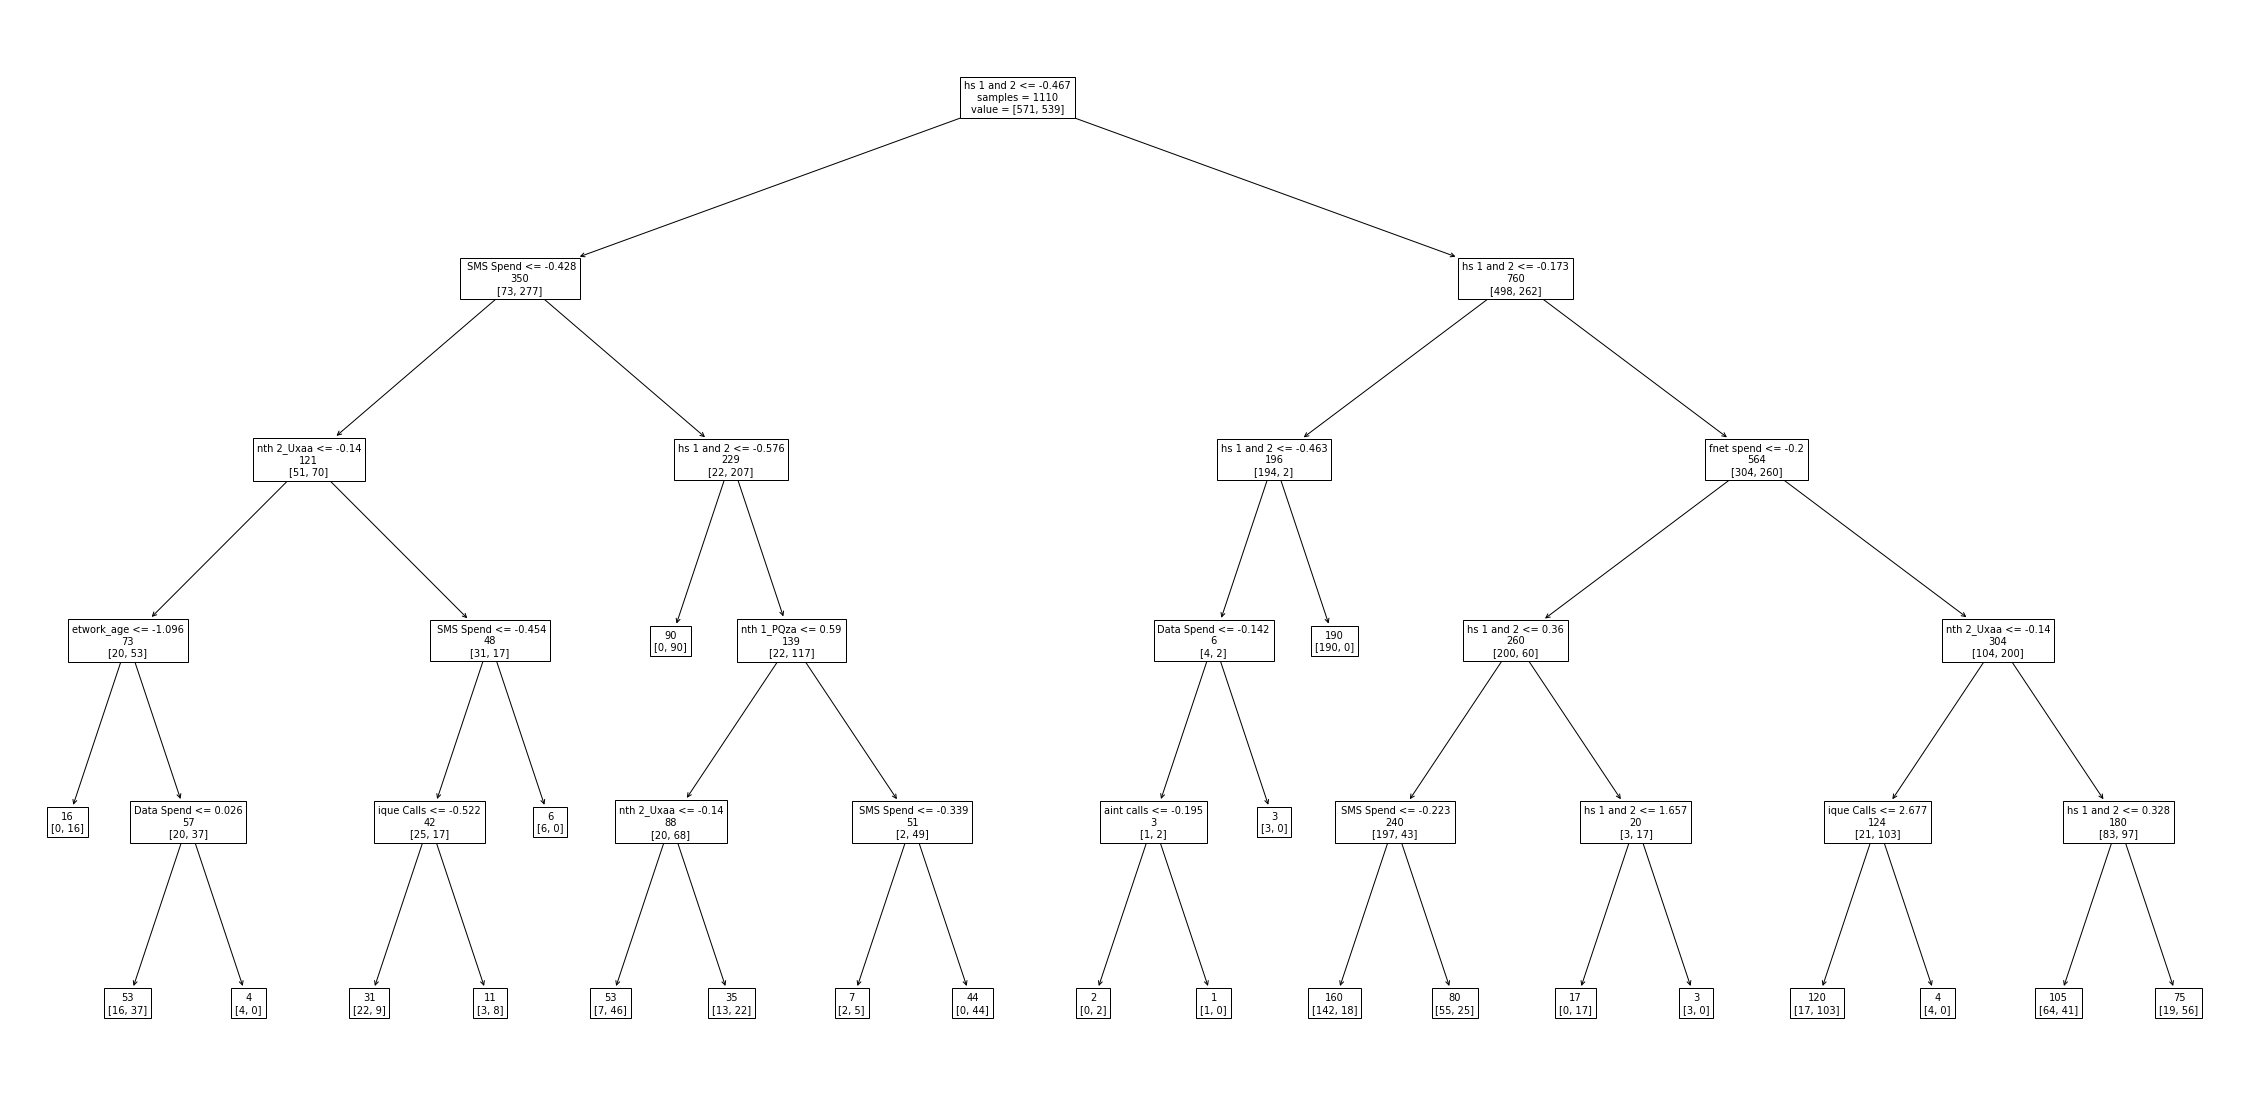

In [19]:
plt.figure(figsize=(40, 20))
plot_tree(model, feature_names=[name[-10:] for name in features], label="root", impurity=False)
plt.show()


### Third model: Neural network

First, we get a list of lists with the possible configurations for the specified number of layers.
Each element will be a list of length = current_layer with the number of neurons for each layer as elements.
For this, all the configurations corresponding to current_layer are stored in config_new. They are obtained from concatenating the configurations of the previous current_layer with each possible number of neurons.

In [20]:
n_layers = 4
n_neurons = [[n] for n in (10, 20, 50, 75, 100, 150)] # Array with the posible amount of neurons per layer
configurations = list(n_neurons)
config_prev = list(n_neurons)

for current_layer in range(1, n_layers):
    config_new = [config + neuron for config in config_prev for neuron in n_neurons]
    configurations += config_new
    config_prev = config_new

The best value of the hyperparameters for the labeled data is computed. As can be seen, this search was carried out on a very wide space of hyperparameters, to obtain an overview of which were the optimal values. The calculation time is exorbitant (around 4 hours), so it is not recommended to run this cell again.

In [21]:
grid_params = {
    'hidden_layer_sizes': configurations,
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': (5000,),
    'solver': ('lbfgs', 'adam')
}

gs = GridSearchCV(MLPClassifier(), grid_params, verbose=True, n_jobs=-1)

# Uncomment these lines if you want your computer to be unusable for 4 hours
# gs_results = gs.fit(X_train, y_train)
# print(f"Best parameters: {gs_results.best_params_} with score {gs_results.best_score_}")

As we have discussed, this search was very expensive. That is why in the next cell we store the values resulting from the analysis. It is too precious to risk losing it and having to run the search again.

The 100 clients most likely to leave are obtained and written to the csv:

In [22]:
# Harcoded best variables
activation = 'logistic'
hidden_layer_sizes = (150, 50, 50)
learning_rate = 'constant'
max_iter = 5000
solver = 'adam'

model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      solver=solver,
                      learning_rate=learning_rate,
                      max_iter=max_iter)

get_error(model)
get_best_ids(model, "predictions/predictions_neuron.csv")

Correct: 78.38%
False positives: 9.01%
False negatives: 12.61%


,Customer ID,Probability
164,ADF0513,0.999894
152,ADF0451,0.999890
109,ADF1975,0.999888
173,ADF0584,0.999883
174,ADF0585,0.999868
...,...,...
127,ADF0291,0.002915
143,ADF0410,0.002915
197,ADF1130,0.002915
144,ADF0417,0.002915


## Matches between the three models

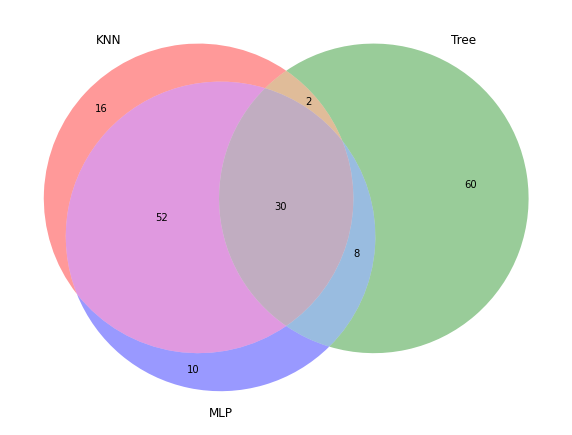

In [23]:
best_ids_knn = set(pd.read_csv("predictions_knn.csv")["Customer ID"].unique())
best_ids_tree = set(pd.read_csv("predictions_tree.csv")["Customer ID"].unique())
best_ids_neuron = set(pd.read_csv("predictions_neuron.csv")["Customer ID"].unique())

plt.figure(figsize=(10, 10))
venn3([best_ids_knn, best_ids_tree, best_ids_neuron], set_labels=("KNN", "Tree", "MLP"))
plt.show()

## Conclusions
In view of the scores obtained, it is not clear which model should be used. It seems good idea to choose the elements predicted by more than one model. The following code takes all the elements that belong to more than one prediction, and fills with random elements that have only been predicen by one model until reaching 100. This list would be the one that we would deliver to the company. In addition, we would warn them that the predictor, when it fails, it is usually due to false positives, that is, it predicts that a customer will leave when he really will not.

In [24]:
sets = (best_ids_knn, best_ids_tree, best_ids_neuron)
# Compute the union of the 3 sets
union = reduce(lambda x, y: x.union(y), sets)
# Compute A Ո B, A Ո C and B Ո C
intersections = [sets[i].intersection(sets[j]) for i in range(3) for j in range(i + 1, 3)]
# Compute the union of the previous sets (all the elements will have been predicted by more than one model)
final_prediction = reduce(lambda x, y: x.union(y), intersections)
# Get those elements that have only been predicen by one model
remaining = union - final_prediction
# Fill the final prediction so it has 100 elements
final_prediction.update(sample(remaining, k=100 - len(final_prediction)))
# Write the prediction into a CSV file
df = pd.DataFrame({"Customer ID": list(final_prediction)})
df.to_csv("predictions/predictions_final.csv", index=False)
df

,Customer ID
0,ADF1975
1,ADF1695
2,ADF1967
3,ADF1956
4,ADF0098
...,...
95,ADF1556
96,ADF1719
97,ADF0480
98,ADF1590
